# Objective : Given amazon food review dataset ,perform t-SNE visualization on the reviews(positive or negative) and check whether its is clearly separable or not

In [21]:
import numpy as np
import pandas as pd
import sqlite3
import warnings

warnings.filterwarnings("ignore")
# Creating DB connection and extracting data
connection=sqlite3.connect('database.sqlite')
filtered_data=pd.read_sql_query("SELECT * FROM Reviews WHERE Score!=3",connection)

# Lets have the data in dataframe pandas and give value 1 for Score >3 and 0 for Score<3
def partition(x):
    if x<3:
        return 0
    else:
        return 1
       
filtered_data['Score']=filtered_data['Score'].map(partition)

#drop duplicates as the dataset has some duplicate records
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
 
# selecting records where denominator >=numerator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# counts of scores
print("Number of positive and negative reviews '1' being positive & '0' being negative :\n", final['Score'].value_counts())

#lets take 2k positive and negative reviews each

positive_reviews=final[final['Score']==1]
negative_reviews=final[final['Score']==0]
positive_reviews=positive_reviews.head(2500)
negative_reviews=negative_reviews.head(2500)

final_dataset=pd.concat([positive_reviews,negative_reviews])
final_score=final_dataset['Score']
print("Final dataset with 2.5k positive & negative reviews for analyis :" , final_dataset.shape)
print("Final score dimension :" ,final_score.shape)

Number of positive and negative reviews '1' being positive & '0' being negative :
 1    307061
0     57110
Name: Score, dtype: int64
Final dataset with 2.5k positive & negative reviews for analyis : (5000, 10)
Final score dimension : (5000,)


In [22]:
# Will import nltk for stopwords ,stemmer and lemmatizer to clean our review text in dataset
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#get list of english language stopwords
stop=set(stopwords.words('english'))

#initialize the english snowballstemmer
sno=nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ushayadu04/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Functions to clean html tags and punctuations from the sentence
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    return (re.sub(cleanr,r'',sentence))
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [24]:
# Now lets run final_dataset to pre process and dump into db
import os
from tqdm import tqdm
import string

final_string=[]
for i, sent in enumerate(tqdm(final_dataset['Text'].values)):
    filtered_sentence=[]
    sent=cleanhtml(sent).split() # remove HTMl tags
    for w in sent:
        for cleaned_words in cleanpunc(w).split():   # remove punctuations
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop): # include only those words which are non-stopwords
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
    joinedsentence = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(joinedsentence)
   
    
final_dataset['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final_dataset['CleanedText']=final_dataset['CleanedText'].str.decode("utf-8")

100%|██████████| 5000/5000 [00:04<00:00, 1226.53it/s]


# BOW calculation and t-SNE visualization

In [8]:
# Lets calculate vector on the 'cleanedText' column using BOW and ngrams as 2

from sklearn.feature_extraction.text import CountVectorizer
bow_count_vect=CountVectorizer(ngram_range=(1,2))   
bow_matrix=bow_count_vect.fit_transform(final_dataset['CleanedText'].values)

print(type(bow_matrix))
print(bow_matrix.get_shape())
print("Number of unique words",bow_matrix.get_shape()[1])

<class 'scipy.sparse.csr.csr_matrix'>
(5000, 132704)
Number of unique words 132704


In [9]:
# Data-preprocessing: Standardizing the data 

from sklearn.preprocessing import StandardScaler
bow_standardized_data = StandardScaler(with_mean = False).fit_transform(bow_matrix)
print(bow_standardized_data.shape)
print(type(bow_standardized_data))

# As bow creates sparse matrix ,lets convert to dense matrix in order to perform t-SNE on it
bow_standardized_data = bow_standardized_data.todense()
bow_standardized_data.shape

(5000, 132704)
<class 'scipy.sparse.csr.csr_matrix'>


/home/ushayadu04/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(5000, 132704)

In [10]:
# t-SNE visualization
import matplotlib.pyplot as plt
import seaborn as sn
from MulticoreTSNE import MulticoreTSNE as TSNE

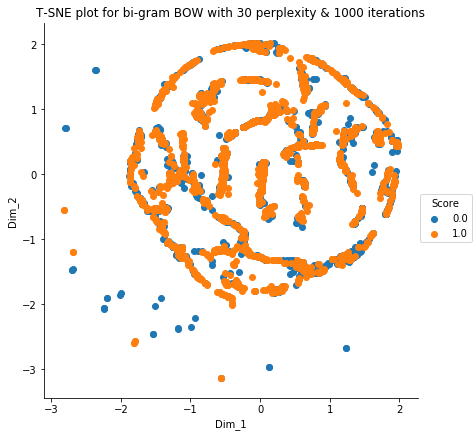

In [11]:

bow_tsne_model = TSNE(n_components=2,random_state=0,n_jobs=4,perplexity=30,n_iter=1000)
bow_tsne_data = bow_tsne_model.fit_transform(bow_standardized_data)

# creating a new data frame which help us in ploting the result data
bow_tsne_data = np.vstack((bow_tsne_data.T,final_score)).T
bow_tsne_df = pd.DataFrame(data=bow_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(bow_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for bi-gram BOW with 30 perplexity & 1000 iterations")
plt.show()

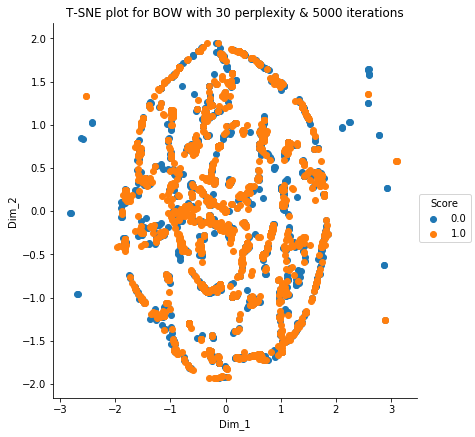

In [9]:

bow_tsne_model = TSNE(n_components=2,random_state=0,n_jobs=4,perplexity=30,n_iter=5000)
bow_tsne_data = bow_tsne_model.fit_transform(bow_standardized_data)

# creating a new data frame which help us in ploting the result data
bow_tsne_data = np.vstack((bow_tsne_data.T,final_score)).T
bow_tsne_df = pd.DataFrame(data=bow_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(bow_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for bi-gram BOW with 30 perplexity & 5000 iterations")
plt.show()

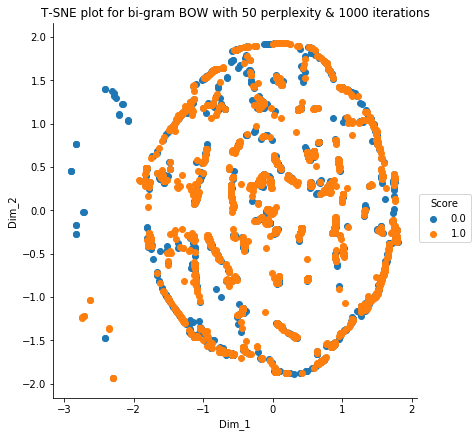

In [12]:

bow_tsne_model = TSNE(n_components=2,random_state=0,n_jobs=4,perplexity=50,n_iter=1000)
bow_tsne_data = bow_tsne_model.fit_transform(bow_standardized_data)

# creating a new data frame which help us in ploting the result data
bow_tsne_data = np.vstack((bow_tsne_data.T,final_score)).T
bow_tsne_df = pd.DataFrame(data=bow_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(bow_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for bi-gram BOW with 50 perplexity & 1000 iterations")
plt.show()

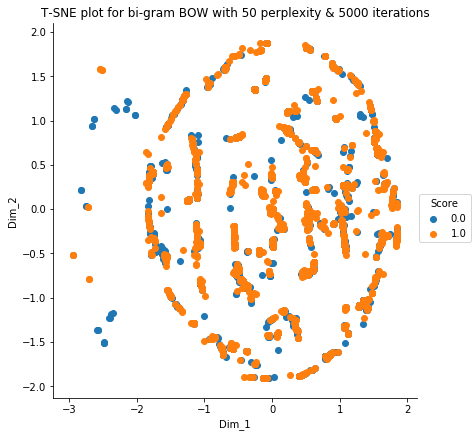

In [13]:

bow_tsne_model = TSNE(n_components=2,random_state=0,n_jobs=4,perplexity=50,n_iter=5000)
bow_tsne_data = bow_tsne_model.fit_transform(bow_standardized_data)

# creating a new data frame which help us in ploting the result data
bow_tsne_data = np.vstack((bow_tsne_data.T,final_score)).T
bow_tsne_df = pd.DataFrame(data=bow_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(bow_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for bi-gram BOW with 50 perplexity & 5000 iterations")
plt.show()

# tfidf calculation and t-SNE visualization

In [11]:
# Lets calculate tfidf

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_dataset['CleanedText'].values)
print("the type of tfidf vectorizer ",type(final_tf_idf))
print("the shape of our text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

the type of tfidf vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text TFIDF vectorizer  (5000, 132704)
the number of unique words including both unigrams and bigrams  132704
some sample features(unique words in the corpus) ['saver ship', 'saver youll', 'savor', 'savor celebr', 'savor day', 'savor enjoy', 'savor ever', 'savor everi', 'savor instead', 'savor pasta']


In [12]:
# Standardized tfidf data

standardized_data_tfidf = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
print(standardized_data_tfidf.shape)

print(type(standardized_data_tfidf))

standardized_data_tfidf = standardized_data_tfidf.todense()
standardized_data_tfidf.shape

(5000, 132704)
<class 'scipy.sparse.csr.csr_matrix'>


(5000, 132704)

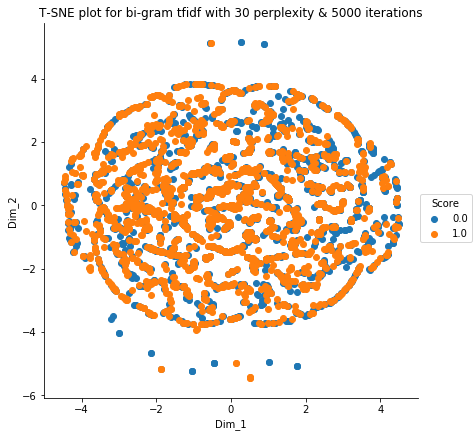

In [13]:
# With perplexity
#tfidf_tsne_model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=5000)
tfidf_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=30,n_iter=5000)
tsne_data_tfidf = tfidf_tsne_model.fit_transform(standardized_data_tfidf)


# creating a new data frame which help us in ploting the result data
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T,final_score)).T
tsne_df_tfidf = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidf, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for bi-gram tfidf with 30 perplexity & 5000 iterations")
plt.show()


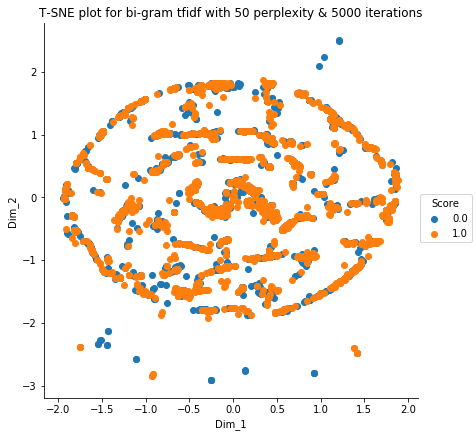

In [14]:
# With perplexity
#tfidf_tsne_model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=5000)
tfidf_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=50,n_iter=5000)
tsne_data_tfidf = tfidf_tsne_model.fit_transform(standardized_data_tfidf)


# creating a new data frame which help us in ploting the result data
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T,final_score)).T
tsne_df_tfidf = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidf, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for bi-gram tfidf with 50 perplexity & 5000 iterations")
plt.show()

# Avg W2V tfidf calculation and t-SNE visualization

In [25]:
# Lets calculate W2V
from gensim import models
i=0
list_of_sent=[]
for sent in final_dataset['CleanedText'].values:
    list_of_sent.append(sent.split())
w2v_model=models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
w2v_model.wv.most_similar('better')

number of words that occured minimum 5 times  3135
sample words  ['bought', 'sever', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'finicki', 'appreci', 'confect', 'around', 'light', 'citrus', 'gelatin', 'nut', 'case', 'cut', 'tini', 'squar', 'coat', 'powder', 'sugar', 'mouth', 'heaven', 'chewi', 'flavor', 'high', 'recommend', 'yummi', 'treat', 'familiar', 'stori', 'sell', 'brother', 'sister', 'great', 'taffi', 'price', 'wide', 'assort', 'deliveri']


[('good', 0.9903459548950195),
 ('much', 0.9858273863792419),
 ('enjoy', 0.9826359748840332),
 ('doesnt', 0.9825424551963806),
 ('regular', 0.9812797904014587),
 ('prefer', 0.9807413816452026),
 ('isnt', 0.980625331401825),
 ('bad', 0.9805713295936584),
 ('noth', 0.9803851246833801),
 ('aftertast', 0.9794371724128723)]

In [26]:
# compute average word2vec tfidf for each review.

tfidf_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_avg_w2v_vectors.append(sent_vec)
tfidf_avg_w2v_vectors=np.array(tfidf_avg_w2v_vectors)  # Convert list of list to numpy array as it 
print(type(tfidf_avg_w2v_vectors))

100%|██████████| 5000/5000 [00:03<00:00, 1315.02it/s]

<class 'numpy.ndarray'>


In [27]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
tfidf_avg_w2v_standardized_data = StandardScaler(with_mean = False).fit_transform(tfidf_avg_w2v_vectors)
print(tfidf_avg_w2v_standardized_data.shape)
print(type(tfidf_avg_w2v_standardized_data))

(5000, 50)
<class 'numpy.ndarray'>


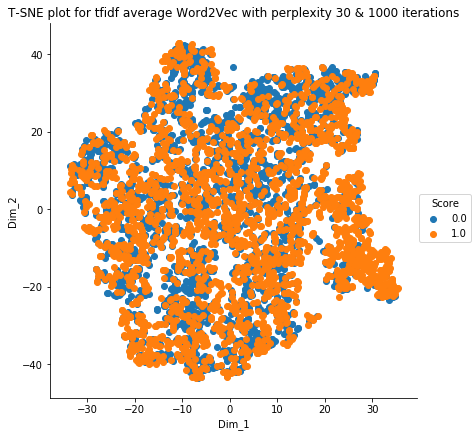

In [30]:
# t-SNE visualization for average Word2Vec tfidf
import matplotlib.pyplot as plt
import seaborn as sn
from MulticoreTSNE import MulticoreTSNE as TSNE


tfidf_avg_w2v_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=30,n_iter=1000)
tfidf_avg_w2v_tsne_data = tfidf_avg_w2v_tsne_model.fit_transform(tfidf_avg_w2v_standardized_data)


# creating a new data frame which help us in ploting the result data
tfidf_avg_w2v_tsne_data = np.vstack((tfidf_avg_w2v_tsne_data.T,final_score)).T
tfidf_avg_w2v_tsne_df = pd.DataFrame(data=tfidf_avg_w2v_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tfidf_avg_w2v_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for tfidf average Word2Vec with perplexity 30 & 1000 iterations")
plt.show()

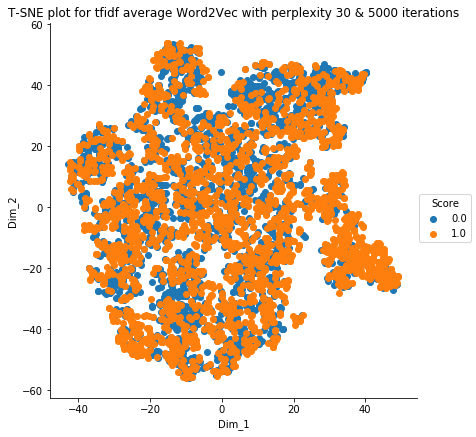

In [31]:
# t-SNE visualization for average Word2Vec tfidf
import matplotlib.pyplot as plt
import seaborn as sn
from MulticoreTSNE import MulticoreTSNE as TSNE


tfidf_avg_w2v_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=30,n_iter=5000)
tfidf_avg_w2v_tsne_data = tfidf_avg_w2v_tsne_model.fit_transform(tfidf_avg_w2v_standardized_data)


# creating a new data frame which help us in ploting the result data
tfidf_avg_w2v_tsne_data = np.vstack((tfidf_avg_w2v_tsne_data.T,final_score)).T
tfidf_avg_w2v_tsne_df = pd.DataFrame(data=tfidf_avg_w2v_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tfidf_avg_w2v_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for tfidf average Word2Vec with perplexity 30 & 5000 iterations")
plt.show()

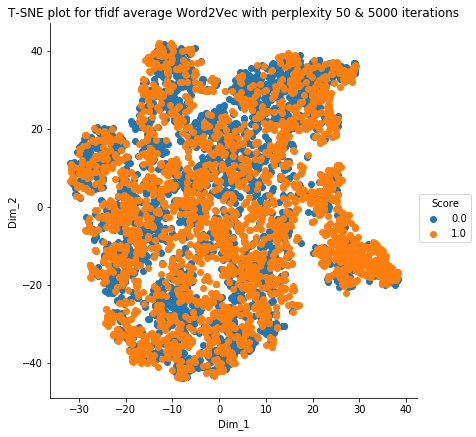

In [28]:
# t-SNE visualization for average Word2Vec tfidf
import matplotlib.pyplot as plt
import seaborn as sn
from MulticoreTSNE import MulticoreTSNE as TSNE


tfidf_avg_w2v_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=50,n_iter=5000)
tfidf_avg_w2v_tsne_data = tfidf_avg_w2v_tsne_model.fit_transform(tfidf_avg_w2v_standardized_data)


# creating a new data frame which help us in ploting the result data
tfidf_avg_w2v_tsne_data = np.vstack((tfidf_avg_w2v_tsne_data.T,final_score)).T
tfidf_avg_w2v_tsne_df = pd.DataFrame(data=tfidf_avg_w2v_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tfidf_avg_w2v_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for tfidf average Word2Vec with perplexity 50 & 5000 iterations")
plt.show()

# Weighted W2V tfidf calculation and t-SNE visualization

In [32]:
# lets store all the features names and corresponding idf in dictionary to calculate TF-IDF weighted Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_dataset['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# Lets calculate TF-IDF weighted Word2Vec
tfidf_weighted_w2v_vectors = []; # the tfidf-weighted-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word)/len(sent) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_weighted_w2v_vectors.append(sent_vec)
    row += 1
print(type(tfidf_weighted_w2v_vectors))
tfidf_weighted_w2v_vectors=np.array(tfidf_weighted_w2v_vectors)  # Convert list of list to numpy array as it 
print(type(tfidf_weighted_w2v_vectors))

100%|██████████| 5000/5000 [00:05<00:00, 911.87it/s] 

<class 'list'>
<class 'numpy.ndarray'>


In [34]:
# Data-preprocessing: Standardizing the data

tfidf_weighted_w2v_standardized_data = StandardScaler(with_mean = False).fit_transform(tfidf_weighted_w2v_vectors)
print(tfidf_weighted_w2v_standardized_data.shape)
print(type(tfidf_weighted_w2v_standardized_data))

(5000, 50)
<class 'numpy.ndarray'>


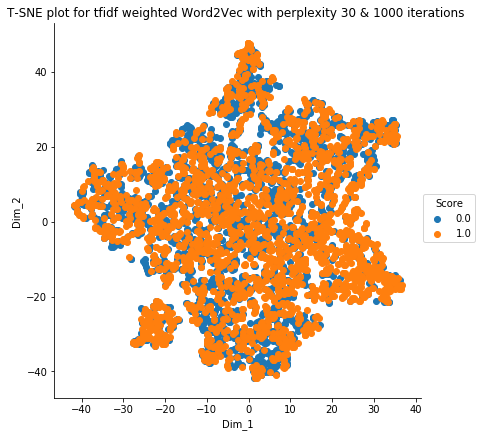

In [35]:
# t-SNE visualization for weighted Word2Vec tfidf

tfidf_weighted_w2v_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=30,n_iter=1000)
tfidf_weighted_w2v_tsne_data = tfidf_weighted_w2v_tsne_model.fit_transform(tfidf_weighted_w2v_standardized_data)


# creating a new data frame which help us in ploting the result data
tfidf_weighted_w2v_tsne_data = np.vstack((tfidf_weighted_w2v_tsne_data.T,final_score)).T
tfidf_weighted_w2v_tsne_df = pd.DataFrame(data=tfidf_weighted_w2v_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tfidf_weighted_w2v_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for tfidf weighted Word2Vec with perplexity 30 & 1000 iterations ")
plt.show()

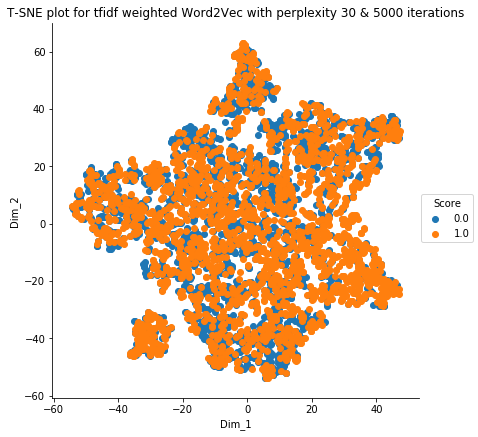

In [36]:
# t-SNE visualization for weighted Word2Vec tfidf

tfidf_weighted_w2v_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=30,n_iter=5000)
tfidf_weighted_w2v_tsne_data = tfidf_weighted_w2v_tsne_model.fit_transform(tfidf_weighted_w2v_standardized_data)


# creating a new data frame which help us in ploting the result data
tfidf_weighted_w2v_tsne_data = np.vstack((tfidf_weighted_w2v_tsne_data.T,final_score)).T
tfidf_weighted_w2v_tsne_df = pd.DataFrame(data=tfidf_weighted_w2v_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tfidf_weighted_w2v_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for tfidf weighted Word2Vec with perplexity 30 & 5000 iterations")
plt.show()

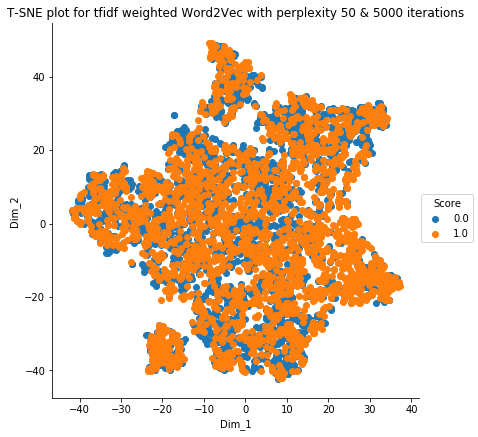

In [37]:
# t-SNE visualization for weighted Word2Vec tfidf

tfidf_weighted_w2v_tsne_model = TSNE(n_components=2, random_state=0,n_jobs=4,perplexity=50,n_iter=5000)
tfidf_weighted_w2v_tsne_data = tfidf_weighted_w2v_tsne_model.fit_transform(tfidf_weighted_w2v_standardized_data)


# creating a new data frame which help us in ploting the result data
tfidf_weighted_w2v_tsne_data = np.vstack((tfidf_weighted_w2v_tsne_data.T,final_score)).T
tfidf_weighted_w2v_tsne_df = pd.DataFrame(data=tfidf_weighted_w2v_tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tfidf_weighted_w2v_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("T-SNE plot for tfidf weighted Word2Vec with perplexity 50 & 5000 iterations")
plt.show()

# Observations :
1)  t-sNE plot of BOW/tfidf/avg W2V tfidf /Weighted W2V tfidf with different perplexity & iterations parameters our class label i.e reviews here , is overlapping and hence t-SNE being powerful unable to separate the class labels in Amazon food review dataset

2)  Trying different parameters is very important to get stable t-SNE model but even after various combinations it is found out that it doesn't help in our case of Amazon Fine Food Reviews dataset to separate them clearly 